In [15]:
#Libraries
import numpy as np
import matplotlib.pyplot as plt
from lmfit import minimize, Parameters 
from scipy.sparse import data
import pandas as pd
import xlsxwriter
import os
from fpdf import FPDF
from numpy.core.fromnumeric import mean, std
from scipy import stats
from math import sqrt

In [16]:
#Main functions used for calculations

def residual1(pars, x, data=None):
    C = pars['C']
    ka = pars['ka']
    k2 = pars['k2']
    model = C*(-np.exp(-ka*x) + np.exp(-k2*x))
    if data is None:
        return model
    return model - data

def residual2(pars, x, data=None):
    C0 = pars['C0']
    C1 = pars['C1']
    C2 = pars['C2']
    ka = pars['ka']
    k2 = pars['k2']
    model = C0+ C1*np.exp(-ka*x) + C2* np.exp(-k2*x)
    if data is None:
        return model
    return model - data

def One_Elimination(x, C1, ka, k2):
    return C1*(-np.exp(-ka*x) + np.exp(-k2*x))

def Two_Elimination(x, C0, C1, C2, ka, k2):
    return C0 + C1*np.exp(-ka*x) + C2* np.exp(-k2*x)

def EGP_analytical_1(t, C0_unl, C1_unl, C2_unl, ka_unl, ke_unl, ka_lab, k1, k2): #in µmol/(kg*min)
    part1 = ((C1_unl*Vol)*(k2-ka_unl)*np.exp(-ka_unl*t) - k1 *  Q1_unl_0*np.exp(-ka_lab*t))
    part2 = ((C2_unl*Vol)*(k2-ke_unl))*np.exp(-ke_unl*t)
    part3 = k2*C0_unl*Vol
    return part1 + part2 + part3


In [ ]:
#The age groups here reported (6, 12, 18 and 24 months) refer to the age in which animals were sacrificed. 
#These represent the groups 4, 9, 15 and 21 months, respectively, as reported in the original manuscript.

### Figure 2 and Figure 3 (parameters)

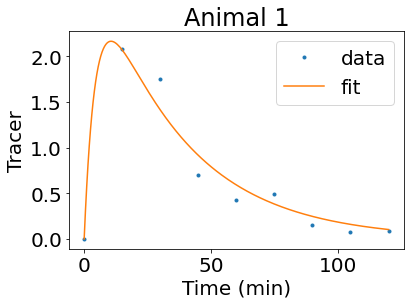

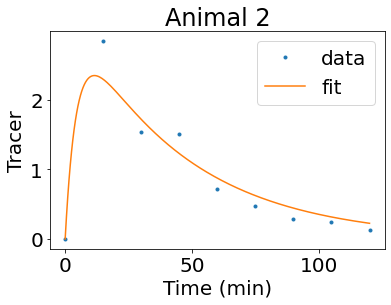

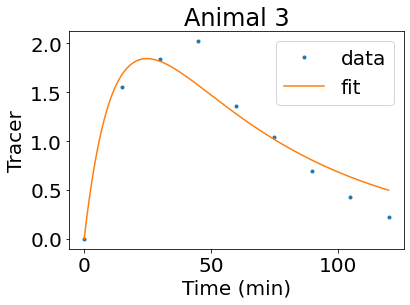

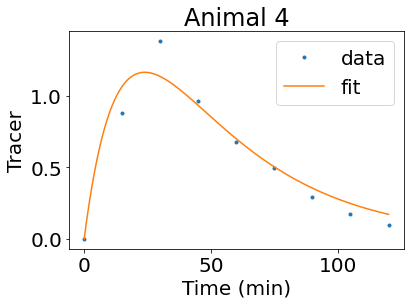

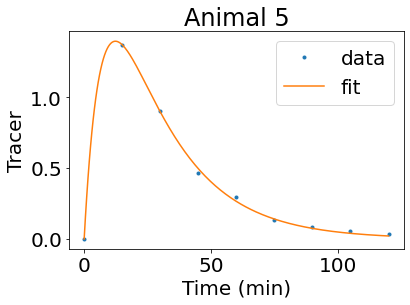

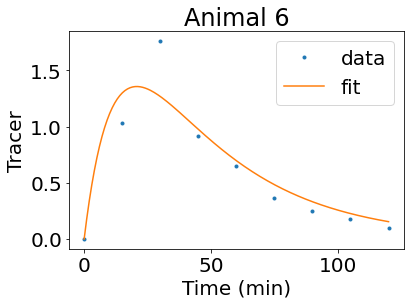

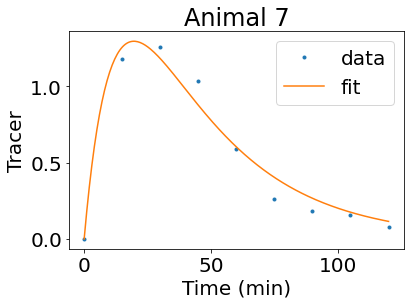

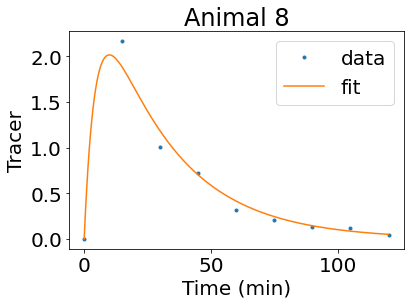

IS_P value: 0.0009373839896654002
IS_P_std value: 0.0005000348829472413
IS_P_sem value: 0.0001767890282809079
ins_avg: 29.9
ins_avg_std: 13.8
n: 8


ValueError: Sheet 'LFAL_6months' already exists and if_sheet_exists is set to 'error'.

In [17]:
#Fitting of all animal curves (tracer)

AIC_full=[]
ka_full = []
k2_full = []
C_full = []
allnames = []
results_lab_1 = [] #vector used to calculate the EGP
        

names = ['LFAL', 'LFRW', 'HFAL', 'HFRW']
age = ['_6months','_12months', '_18months', '_24months']
for i in range(len(names)):
    for j in range (len(age)):
                
        name_group = names[i]+age[j]
        allnames.append(name_group)
        results_lab_2=[]
        
        if name_group == 'LFAL_6months':
            ins_avg = 29.9
            ins_avg_std = 13.8
            n_ins = 8
        if name_group == 'LFRW_6months':
            ins_avg = 20.3 #animal 6.5 removed
            ins_avg_std = 5.8 #animal 6.5 removed
            n_ins = 7
        if name_group == 'HFAL_6months':
            ins_avg = 67.2
            ins_avg_std = 23.5
            n_ins = 8
        if name_group == 'HFRW_6months':
            ins_avg = 74.0
            ins_avg_std = 19.8
            n_ins = 6
        if name_group == 'LFAL_12months':
            ins_avg = 67.8
            ins_avg_std = 41.8
            n_ins = 7
        if name_group == 'LFRW_12months':
            ins_avg = 39.3
            ins_avg_std = 16.6
            n_ins = 8
        if name_group == 'HFAL_12months':
            ins_avg = 123.3
            ins_avg_std = 24.0
            n_ins = 7
        if name_group == 'HFRW_12months':
            ins_avg = 67.5
            ins_avg_std = 30.7
            n_ins = 7
        if name_group == 'LFAL_18months': #animal 18.13 removed --> outlier
            ins_avg = 69.0
            ins_avg_std = 30.4
            n_ins = 8
        if name_group == 'LFRW_18months':
            ins_avg = 38.3
            ins_avg_std = 12.5
            n_ins = 8
        if name_group == 'HFAL_18months':
            ins_avg = 91.5
            ins_avg_std = 24.9
            n_ins = 8
        if name_group == 'HFRW_18months':
            ins_avg = 95.1
            ins_avg_std = 32.9
            n_ins = 7
        if name_group == 'LFAL_24months':
            ins_avg = 65.2
            ins_avg_std = 27.4
            n_ins = 8
        if name_group == 'LFRW_24months':
            ins_avg = 56.6
            ins_avg_std = 25.2
            n_ins = 8
        if name_group == 'HFAL_24months':
            ins_avg = 123.0
            ins_avg_std = 11.5
            n_ins = 8
        if name_group == 'HFRW_24months':
            ins_avg = 101.8
            ins_avg_std = 18.4
            n_ins = 8

        data_lab = pd.read_excel('tracer concentration (filtered).xlsx', name_group) # for EGP calculation: 'tracer concentration (filtered).xlsx'
        t1 = data_lab['Time (min)'].to_numpy()
        average_data = data_lab['average'].to_numpy()

        matrix_lab = np.array(data_lab)
        datafile_lab = np.delete(matrix_lab, [0,1],1)
        datafile_lab = datafile_lab.T
        
        # create a pdf file that contains all the parameters and the curve fits
        pdf = FPDF()
        pdf.add_page()
        pdf.set_font('Arial', 'B', 16)
        pdf.cell(0, 20, '%s animal parameters and curves' %name_group, 0, 1,align='C')
        pdf.set_font('Arial', 'B', 12)
        pdf.cell(0, 10, 'General parameters', 0, 1)
        pdf.set_font('Arial', '', 12)
        pdf.cell(0, 10, 'c_initial = 4 (%s - %s)' %(0.1*4,10*4) , 0, 1)
        pdf.cell(0, 10, 'ka_initial = 0.06 (%s - %s)' %(0.1*0.06,10*0.06), 0, 1)
        pdf.cell(0, 10, 'k2_initial = 0.025 (%s - %s)' %(0.1*0.025,10*0.025), 0, 1)
        pdf.cell(0, 10, 'ins_avg = %s' %ins_avg, 0, 1)

        # create arrays that will retain all the MISI, k2 and average fit values
        MISI_all = []
        c_all = []
        ka_all = []
        k2_all = []
        aic_all = []
        average_fit = []

        # derive the IS-P values from each set of animal data
        n = np.shape(datafile_lab)[0]
        for k in range(0,n):
            # remove any nan in the tracer data
            if np.isnan(datafile_lab[[k][0]]).any():
                nan_index = np.where(np.isnan(datafile_lab[[k][0]]))
                y_values = np.delete(datafile_lab[[k][0]],nan_index)
                x_values = np.delete(t1,nan_index)
            else:
                y_values = datafile_lab[[k][0]]
                x_values = t1
            
            C_= 3.4 #to change C value
            ka_=0.082
            k2_=0.025

           # set parameters including bounds; you can also fix parameters (use vary=False)
            params = Parameters()
            params.add('C', value=C_, vary = False) 
            params.add('ka', value=ka_, min = 0.047, max = 0.22) 
            params.add('k2', value=k2_) 

            result = minimize(residual1, params, args=(x_values, y_values), method='leastsq')
            c=result.params['C'].value
            ka=result.params['ka'].value
            k2=result.params['k2'].value
            results_vector = [c, ka, k2]
            results_lab_2.append(results_vector)
            
            # obtain the c, ka, and k2 values
            c_all.append(c)
            ka_all.append(ka)
            k2_all.append(k2)
            aic_all.append(result.aic)
            AIC_full.append(result.aic)
            ka_full.append(ka)
            k2_full.append(k2)
            C_full.append(c)

            # create a figure that contains all plots
            fig,axes = plt.subplots(1)

            # plot the actual data
            axes.plot(x_values, y_values,".", label="data")

            # make a smooth line out of the fitted curve
            xnew = np.linspace(x_values.min(), x_values.max(), 240) 

            # plot the fitted curve
            axes.plot(xnew, One_Elimination(xnew, c, ka, k2), label="fit")
            axes.set_xlabel('Time (min)')
            axes.set_ylabel('Tracer')
            axes.set_title('Animal %s' %(k+1))
            axes.legend()
            plt.show()

            # export the plots in png file
            # fig.savefig('curve fit %s.png' %k)

            # add the parameters and the curve fits for each animal in a pdf file
            pdf.set_font('Arial', 'B', 12)
            pdf.cell(60, 10, 'Parameters for animal %s' %(k+1), 0, 1,)
            pdf.set_font('Arial', '', 12)
            pdf.cell(60, 10, 'c  = %s' %c, 0, 1)
            pdf.cell(60, 10, 'ka  = %s' %ka, 0, 1)
            pdf.cell(60, 10, 'k2 = %s' %k2, 0, 1)
            # pdf.image('curve fit %s.png' %k,x=30,w =150)

            average_fit.append(One_Elimination(xnew, c, ka, k2))
        
        results_lab_1.append(results_lab_2)
        no_mice = []

        for k in range(0,n):
            no_mice.append('mouse %s' %(k+1))
            
        a=1 #set 'a' to 1 if reports below are desired
        if a==1: 
            k2_avg = mean(k2_all)
            k2_avg_std = std(k2_all)
            n_k2 = len(k2_all)

            # obtain the IS-P value and its standard deviation
            IS_P = k2_avg/ins_avg
            IS_P_sem = np.sqrt(k2_avg_std**2/(n_k2*ins_avg**2) + (k2_avg**2/ins_avg**2)*(ins_avg_std**2/(n_ins*ins_avg**2)))
            IS_P_std = np.sqrt(k2_avg_std**2/(ins_avg**2) + (k2_avg**2/ins_avg**2)*(ins_avg_std**2/(ins_avg**2)))
            n_prod = round((IS_P_std/IS_P_sem)**2,0)

            print('IS_P value: %s' %IS_P)
            print('IS_P_std value: %s' %IS_P_std)
            print('IS_P_sem value: %s' %IS_P_sem)
            print('ins_avg: %s' %ins_avg)
            print('ins_avg_std: %s' %ins_avg_std)
            print('n: %s' %n)

            # export the pdf file
            pdf.output('%s animal parameters and curves.pdf' %name_group, 'F')

            # create an excel file with all the IS_P values
            d = {'IS_P': IS_P, 'standard error': IS_P_sem, 'n_product': n_prod,'standard deviation': IS_P_std}
            df1 = pd.DataFrame(data=d,index=[0])

            if os.path.exists('IS_P values.xlsx'):
                with pd.ExcelWriter('IS_P values.xlsx',mode = 'a',engine='openpyxl') as writer:
                    df1.to_excel(writer,sheet_name=name_group)
            else:
                df1.to_excel('IS_P values.xlsx',sheet_name=name_group)

            # create an excel file with all the c values
            df2 = pd.DataFrame(c_all).T
            df2.columns = no_mice
            df2.index = ['c']

            if os.path.exists('c values.xlsx'):
                with pd.ExcelWriter('c values.xlsx',mode = 'a',engine='openpyxl') as writer:
                    df2.to_excel(writer,sheet_name=name_group)
            else:
                df2.to_excel('c values.xlsx',sheet_name=name_group)


            # create an excel file with all the ka values
            df3 = pd.DataFrame(ka_all).T
            df3.columns = no_mice
            df3.index = ['ka']

            if os.path.exists('ka values.xlsx'):
                with pd.ExcelWriter('ka values.xlsx',mode = 'a',engine='openpyxl') as writer:
                    df3.to_excel(writer,sheet_name=name_group)
            else:
                df3.to_excel('ka values.xlsx',sheet_name=name_group)

            # create an excel file with all the k2 values
            df4 = pd.DataFrame(k2_all).T
            df4.columns = no_mice
            df4.index = ['k2']

            if os.path.exists('k2 values.xlsx'):
                with pd.ExcelWriter('k2 values.xlsx',mode = 'a',engine='openpyxl') as writer:
                    df4.to_excel(writer,sheet_name=name_group)
            else:
                df4.to_excel('k2 values.xlsx',sheet_name=name_group)

        df5 = pd.DataFrame(aic_all).T
        df5.columns = no_mice
        df5.index = ['aic']

        if os.path.exists('aic values.xlsx'):
            with pd.ExcelWriter('aic values.xlsx',mode = 'a',engine='openpyxl') as writer:
                df5.to_excel(writer,sheet_name=name_group)
        else:
            df5.to_excel('aic values.xlsx',sheet_name=name_group)


        # create a plot with the average fit and a shaded area around it representing the deviation of the fits from the average
        average_fit = np.array(average_fit)
        averages = []
        standard_deviations = []
        error_bars = []

        for k in range(0,np.shape(average_fit)[1]):
            averages.append(mean(average_fit[:,k]))
            standard_deviations.append(std(average_fit[:,k]))

        for k in range(0,np.shape(datafile_lab)[1]):
            error_bars.append(np.nanstd(datafile_lab[:,k]))

        averages = np.array(averages)
        standard_deviations = np.array(standard_deviations)

        fig2, ax = plt.subplots(1)
        ax.errorbar(t1,average_data,error_bars,fmt='.')
        ax.plot(xnew,averages,'-')
        ax.set_xlabel('Time (min)', fontsize=16)
        ax.set_ylabel('Tracer (mM)', fontsize=16)
        # ax.set_title('%s curve fit' %name_group)
        plt.rcParams['font.size'] = '16'
        ax.set(ylim=(0.0, 3.2))
        # Set tick font size
        for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontsize(12)
        bound_lower = averages - standard_deviations
        bound_upper = averages + standard_deviations
        ax.fill_between(xnew, bound_lower, bound_upper,
                         color = 'black', alpha = 0.15)
        plt.show()

        fig2.savefig('%s tracer curve fit.png' %name_group, dpi=600)
        

### Supplemental Text 3: Figure A2 (A, B, C, D, E, F, G)

In [ ]:
fig2, ax = plt.subplots(1)
x=ka_full #Choose from ka_full, k2_full, C_full, AIC_full
y=k2_full #Choose from ka_full, k2_full, C_full, AIC_full
ax.plot(x, y, 'o', color='black') 
ax.set_xlabel('x', fontsize=16) #Choose x label
ax.set_ylabel('y', fontsize=16) #Choose y label
plt.rcParams['font.size'] = '16'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(12)
plt.show()
name_figure = 'nameofchoice.png' #choose name of figure to be saved
fig2.savefig(name_figure, dpi=600)

### Figure 4

In [ ]:
#Fitting of all animal curves (unlabelled glucose)

C0_matrix = []
C1_matrix = []
C2_matrix = []
ka_matrix = []
k2_matrix = []
AIC_matrix = []
allnames = []
results_unl_1=[]

names = ['LFAL', 'LFRW', 'HFAL', 'HFRW']
age = ['_6months','_12months', '_18months', '_24months']

counter = 0

for i in range(len(names)):
    for j in range (len(age)):        
        C0_vector = []
        C1_vector = []
        C2_vector = []
        ka_vector = []
        k2_vector = []
        AIC_vector = []
        name_group = names[i]+age[j]
        allnames.append(name_group)
        print(name_group)

        data_unl = pd.read_excel('glucose concentration (filtered).xlsx', name_group) # add (filtered) for EGP calculation
        t1 = data_unl['Time (min)'].to_numpy()
        average_data = data_unl['average'].to_numpy()

        matrix_unl = np.array(data_unl)
        datafile_unl = np.delete(matrix_unl, [0,1],1)
        datafile_unl = datafile_unl.T
        
        #import ka from tracer to fix the parameter
        #data_ka = pd.read_excel('ka values.xlsx', name_group) #Exported from tracer fits
        #data_ka = np.array(data_ka)
        #data_ka = data_ka[0,1:].tolist()
        
        # create a pdf file that contains all the parameters and the curve fits
        pdf = FPDF()
        pdf.add_page()
        pdf.set_font('Arial', 'B', 16)
        pdf.cell(0, 20, '%s animal parameters and curves' %name_group, 0, 1,align='C')
        pdf.set_font('Arial', 'B', 12)
        pdf.cell(0, 10, 'General parameters', 0, 1)
        pdf.set_font('Arial', '', 12)
        pdf.cell(0, 10, 'c0_initial = 2 (%s - %s)' %(0.1*2,10*2) , 0, 1)
        pdf.cell(0, 10, 'c1_initial = -28 (%s - %s)' %(-10*28,0.1*28) , 0, 1)
        pdf.cell(0, 10, 'c2_initial = 60 (%s - %s)' %(0.1*60,10*60) , 0, 1)
        pdf.cell(0, 10, 'ka_initial = 0.011 (%s - %s)' %(0.1*0.011,10*0.011), 0, 1)
        pdf.cell(0, 10, 'k2_initial = 0.035 (%s - %s)' %(0.1*0.035,10*0.035), 0, 1)
        
        # create arrays that will retain all fiting parameters
        c0_all = []
        c1_all = []
        c2_all = []
        ka_all = []
        k2_all = []
        average_fit = []
        results_unl_2 = [] #used for EGP calculation

        # derive the parameters of interest from each set of animal data
        n = np.shape(datafile_unl)[0]
        for k in range(0,n):
            # remove any nan in the dataset
            if np.isnan(datafile_unl[k]).any():
                nan_index = np.where(np.isnan(datafile_unl[k]))
                data_unl = np.delete(datafile_unl[k],nan_index)
                t = np.delete(t1,nan_index)
            else:
                data_unl = datafile_unl[k]
                t = t1
            
            C0_ = data_unl[0]
            C1_ = -10
            C2_ = 10
            ka_ = results_lab_1[counter][k][1] #ka is imported from tracer fit
            k2_ = 0.025

           # set parameters including bounds; you can also fix parameters (use vary=False)
            params = Parameters()
            params.add('C0', value=C0_, min = 0, max = +np.inf)
            params.add('C1', value=C1_, min = -np.inf, max = 0)
            params.add('C2', value=C2_, min = 0, max = +np.inf) 
            params.add('ka', value=ka_, vary = False) 
            params.add('k2', value=k2_, min = 0, max = +np.inf) 

            result = minimize(residual2, params, args=(t, data_unl), method='leastsq')
            c0=result.params['C0'].value
            c1=result.params['C1'].value
            c2=result.params['C2'].value
            ka=result.params['ka'].value
            k2=result.params['k2'].value
            results_vector = [c0, c1, c2, ka, k2]
            results_unl_2.append(results_vector)
            
            # obtain the c, ka, and k2 values
            c0_all.append(c0)
            c1_all.append(c1)
            c2_all.append(c2)
            ka_all.append(ka)
            k2_all.append(k2)

            # create a figure that contains all plots
            fig,axes = plt.subplots(1)

            # plot the actual data
            axes.plot(t, data_unl,".", label="data")

            # make a smooth line out of the fitted curve
            xnew = np.linspace(t.min(), t.max(), 240) 

            # plot the fitted curve
            axes.plot(xnew, Two_Elimination(xnew, c0, c1, c2, ka, k2), label="fit")
            axes.set_xlabel('Time (min)')
            axes.set_ylabel('Glucose (mM)')
            axes.set_title('Animal %s' %(k+1))
            axes.legend()
            plt.show()

            # export the plots in png file
            fig.savefig('curve fit %s.png' %k)

            # add the parameters and the curve fits for each animal in a pdf file
            pdf.set_font('Arial', 'B', 12)
            pdf.cell(60, 10, 'Parameters for animal %s' %(k+1), 0, 1,)
            pdf.set_font('Arial', '', 12)
            pdf.cell(60, 10, 'c0  = %s' %c0, 0, 1)
            pdf.cell(60, 10, 'c1  = %s' %c1, 0, 1)
            pdf.cell(60, 10, 'c2  = %s' %c2, 0, 1)
            pdf.cell(60, 10, 'ka  = %s' %ka, 0, 1)
            pdf.cell(60, 10, 'k2 = %s' %k2, 0, 1)
            pdf.image('curve fit %s.png' %k,x=30,w =150)

            # remove the plot
            os.remove('curve fit %s.png' %k)
            average_fit.append(Two_Elimination(xnew, c0, c1, c2, ka, k2))
        
        
        # export the pdf file
        #pdf.output('%s animal parameters and curves.pdf' %name_group, 'F')
        counter = counter + 1

        # create an excel file with all the c values
        results_unl_1.append(results_unl_2)
        no_mice = []
        for k in range(0,n):
            no_mice.append('mouse %s' %(k+1))

        # create a plot with the average fit and a shaded area around it representing the deviation of the fits from the average
        average_fit = np.array(average_fit)
        averages = []
        standard_deviations = []
        error_bars = []

        for k in range(0,np.shape(average_fit)[1]):
            averages.append(mean(average_fit[:,k]))
            standard_deviations.append(std(average_fit[:,k]))

        for k in range(0,np.shape(datafile_unl)[1]):
            error_bars.append(np.nanstd(datafile_unl[:,k]))

        averages = np.array(averages)
        standard_deviations = np.array(standard_deviations)

        fig2, ax = plt.subplots(1)
        ax.errorbar(t,average_data,error_bars,fmt='.')
        ax.plot(xnew,averages,'-')
        ax.set_xlabel('Time (min)', fontsize=20)
        ax.set_ylabel('Glucose (mM)', fontsize=20)
        # ax.set_title('%s curve fit' %name_group)
        plt.rcParams['font.size'] = '20'
        ax.set(ylim=(0.0, 28))
        ax.xaxis.set_ticks(np.arange(0, 121, 20))
        # Set tick font size
        for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontsize(18)
        bound_lower = averages - standard_deviations
        bound_upper = averages + standard_deviations
        ax.fill_between(xnew, bound_lower, bound_upper,
                         color = 'black', alpha = 0.15)
        plt.show()

        fig2.savefig('%s tracer curve fit.png' %name_group, dpi=600,  bbox_inches='tight')

### Figure 5

In [ ]:
t2 = np.linspace(0, 120, 241)
F = 0.8
q1_lab_0 = 1600 #µmol/kg
Q1_unl_0 = 3900 #µmol/kg

counter = 0 #this number defines how many groups to go through for the calculation (16 groups)
for i in range(len(names)):
    for j in range (len(age)):
               
        EGP_matrix1 = []
        EGP_matrix2 = []
        Vol_matrix = []
        EGP_matrix1.append(t2)
        EGP_matrix2.append(t2)
        EGP_SS=[]
        EGP_average5_120min = []
        EGP_average120min = []
        
        name_group = names[i]+age[j]
        allnames.append(name_group)
        print(name_group)

        n=len(results_lab_1[counter]) #size of the array
        average_fit = [] # for plots

        for k in range(0,n):
            vector_lab = results_lab_1[counter][k] # C1, ka, ke
            vector_unl = results_unl_1[counter][k] # C0, C1, C2, ka, ke
            #print(vector_lab) 
            #print(vector_unl)

            C1_lab = vector_lab[0]
            ka_lab = vector_lab[1]
            k2 = vector_lab[2]
            k1 = F * ka_lab
            Vol= k1*(q1_lab_0)/(-C1_lab*(k2-ka_lab))
            print('Vol (animal %s): %s' %(k+1,Vol))
            Vol_matrix.append(Vol)

            C0_unl = vector_unl[0]
            C1_unl = vector_unl[1]
            C2_unl = vector_unl[2]
            ka_unl = vector_unl[3]
            ke_unl = vector_unl[4]

            EGP_umol_kg_min = EGP_analytical_1(t2, C0_unl, C1_unl, C2_unl, ka_unl, ke_unl, ka_lab,k1, k2)
            EGP_matrix1.append(EGP_umol_kg_min)
            EGP_mM_min=EGP_analytical_1(t2, C0_unl, C1_unl, C2_unl, ka_unl, ke_unl, ka_lab,k1, k2)/Vol #calculates EGP in mM/min
            EGP_matrix2.append(EGP_mM_min)

            tslice1=90 #min
            tslice2=120 #min
            tslice1b=5 #min

            EGP_slice = EGP_umol_kg_min[tslice1*2:tslice2*2] #defines a time range to be plotted
            EGP_sliceb = EGP_umol_kg_min[tslice1b*2:tslice2*2] #defines a time range to be plotted

            EGP_SS.append(np.mean(EGP_slice))
            EGP_average5_120min.append((np.mean(EGP_sliceb)))
            EGP_average120min.append(np.mean(EGP_umol_kg_min))
            average_fit.append(EGP_umol_kg_min) #Choose EGP_mM_min to plot EGP in mM/min

        # create a plot with the average EGP time course and a shaded area around it representing the deviation of the animal data from the average    
        average_fit = np.array(average_fit)

        averages = []
        standard_errors = []
        counter=counter+1 

        for k in range(0,np.shape(average_fit)[1]):
            averages.append(np.mean(average_fit[:,k]))
            standard_errors.append(stats.sem(average_fit[:,k]))

        averages = np.array(averages)
        standard_errors = np.array(standard_errors)

        fig2, ax = plt.subplots(1)
        ax.plot(t2[10:],averages[10:],'-')   #10: to start plot at 5 min

        ax.set_xlabel('Time (min)', fontsize=20)
        ax.set_ylabel('EGP (μmol·min⁻¹·kg⁻¹)', fontsize=20)
        ax.set_xlim([0, 120])
        ax.set_ylim([-100, 350]) 
        #ax.set_ylim([-0.25,0.75]) #Choose this y axis limit if EGP is plotted in mM/min
        ax.xaxis.set_ticks(np.arange(0, 121, 20))
        plt.axhline(y=0.0, color='b', linestyle='dotted')
        #ax.set_title('%s EGP' %name_group)
        plt.rcParams['font.size'] = '20'

        # Set tick font size
        for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontsize(18)
        bound_lower = averages - standard_errors
        bound_upper = averages + standard_errors
        ax.fill_between(t2[10:], bound_lower[10:], bound_upper[10:],
                         color = 'black', alpha = 0.15) #10: is to start plot at 5 min

        fig2.savefig('%s EGP.png' %name_group, dpi=600, bbox_inches='tight') #tight to save complete graph with no cut off part

        # report the average steady-state EGP value (0-120 min)
        average_EGP = np.mean(EGP_average120min)
        average_EGP_sem = stats.sem(EGP_average120min)
        #print('average steady-state EGP: %s' %average_EGP)
        #print('standard error of the average steady-state EGP: %s' %average_EGP_sem)

        
        #Export EGP data
        df1 = pd.DataFrame(EGP_matrix1)
        df2 = pd.DataFrame(EGP_matrix2)
        df3 = pd.DataFrame(Vol_matrix)
        df4 = pd.DataFrame(EGP_SS)
        df5 = pd.DataFrame(EGP_average120min)
        df6 = pd.DataFrame(EGP_average5_120min)

        name_export_EGP = name_group+'_EGP.xlsx'

        with pd.ExcelWriter(name_export_EGP) as writer:
            df1.T.to_excel(writer, sheet_name='EGP in µmol-minKg')
            df2.T.to_excel(writer, sheet_name='EGP in mM-min')
            df3.to_excel(writer, sheet_name='estimated Vol')
            df4.to_excel(writer, sheet_name='EGP SS (last 30 min)')
            df5.to_excel(writer, sheet_name='EGP average 120 min')
            df6.to_excel(writer, sheet_name='EGP average 5min to 120 min')
            
            
        #insulin values defined below to calculate the IS-L parameter
        if name_group == 'LFAL_6months':
            ins_avg = 29.9
            ins_avg_std = 13.8
            n_ins = 8
        if name_group == 'LFRW_6months':
            ins_avg = 20.3 #animal 6.5 removed
            ins_avg_std = 5.8 #animal 6.5 removed
            n_ins = 7
        if name_group == 'HFAL_6months':
            ins_avg = 67.2
            ins_avg_std = 23.5
            n_ins = 8
        if name_group == 'HFRW_6months':
            ins_avg = 74.0
            ins_avg_std = 19.8
            n_ins = 6
        if name_group == 'LFAL_12months':
            ins_avg = 67.8
            ins_avg_std = 41.8
            n_ins = 7
        if name_group == 'LFRW_12months':
            ins_avg = 39.3
            ins_avg_std = 16.6
            n_ins = 8
        if name_group == 'HFAL_12months':
            ins_avg = 123.3
            ins_avg_std = 24.0
            n_ins = 7
        if name_group == 'HFRW_12months':
            ins_avg = 67.5
            ins_avg_std = 30.7
            n_ins = 7
        if name_group == 'LFAL_18months': #animal 18.13 removed --> outlier
            ins_avg = 69.0
            ins_avg_std = 30.4
            n_ins = 8
        if name_group == 'LFRW_18months':
            ins_avg = 38.3
            ins_avg_std = 12.5
            n_ins = 8
        if name_group == 'HFAL_18months':
            ins_avg = 91.5
            ins_avg_std = 24.9
            n_ins = 8
        if name_group == 'HFRW_18months':
            ins_avg = 95.1
            ins_avg_std = 32.9
            n_ins = 7
        if name_group == 'LFAL_24months':
            ins_avg = 65.2
            ins_avg_std = 27.4
            n_ins = 8
        if name_group == 'LFRW_24months':
            ins_avg = 56.6
            ins_avg_std = 25.2
            n_ins = 8
        if name_group == 'HFAL_24months':
            ins_avg = 123.0
            ins_avg_std = 11.5
            n_ins = 8
        if name_group == 'HFRW_24months':
            ins_avg = 101.8
            ins_avg_std = 18.4
            n_ins = 8    
            
        ins_inverse_avg = 1/ins_avg
        ins_inverse_std = ins_avg_std/ins_avg**2
        
        EGP_avg = mean(EGP_average5_120min)
        EGP_std = std(EGP_average5_120min)
        n_EGP = len(EGP_average5_120min)
        
        EGP_inverse_avg = 1/EGP_avg
        EGP_inverse_std = EGP_std/EGP_avg**2
        
        normalization_factor = 9489 # product of average EGP and average insulin considering ALL experimental groups
        
        IS_L = EGP_inverse_avg*ins_inverse_avg*normalization_factor #calculates the IS-P
        IS_L_std = normalization_factor*sqrt(ins_inverse_avg**2 * EGP_inverse_std**2 + EGP_inverse_avg**2 * ins_inverse_std**2 + EGP_inverse_std**2 * ins_inverse_std**2)
        IS_L_sem = normalization_factor*sqrt((ins_inverse_avg**2 * EGP_inverse_std**2)/n_EGP + (EGP_inverse_avg**2 * ins_inverse_std**2)/n_ins + (EGP_inverse_std**2 * ins_inverse_std**2)/(n_EGP*n_ins))
        apparent_n_IS_L = round((IS_L_std/IS_L_sem)**2)
        
        print(name_group,':', IS_L)
        
        # create an excel file with all the IS_L values
        d = {'IS_L': round(IS_L,3), 'standard deviation': round(IS_L_std,3), 'standard error': round(IS_L_sem,3), 'apparent n': apparent_n_IS_L}

        df1 = pd.DataFrame(data=d,index=[0])

        if os.path.exists('IS_L values.xlsx'):
            with pd.ExcelWriter('IS_L values.xlsx',mode = 'a',engine='openpyxl') as writer:
                df1.to_excel(writer,sheet_name=name_group)
        else:
            df1.to_excel('IS_L values.xlsx',sheet_name=name_group)